<a href="https://colab.research.google.com/github/swankymaks/Sentiment-Analysis-using-keras-functional-API/blob/master/Copy_of_AI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

Using TensorFlow backend.


In [0]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: gast, keras-applications, protobuf, tensorboard, absl-py, numpy, opt-einsum, keras-preprocessing, six, termcolor, grpcio, wheel, wrapt, astor, google-pasta, tensorflow-estimator
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd 
data=pd.read_csv('gdrive/My Drive/yelp_review.csv')

In [0]:
yelp_data= data[:4000]

In [0]:
yelp_data.head(10)

In [0]:
yelp_data.shape

(4000, 9)

Converting the numerical values for the reviews into categorical ones and add a new column "reviews_score" to the dataset. Stars rating column. if stars =4 or 5,reviews score is classified as good if stars = 2 0r 3, reviews score is classified as average if stars = 1, reviews score is classified as bad.

In [0]:
#preprocessing
bins = [0,1,3,5]
names = ['bad', 'average', 'good']
yelp_data['reviews_score'] = pd.cut(yelp_data['stars'], bins, labels=names)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#removing null values
yelp_data.isnull().values.any()#removing null values
print(yelp_data.shape)#looking at the dimension of our data
yelp_data.head()#viewing he first few columns of the data

(4000, 10)


,review_id,user_id,business_id,stars,date,text,useful,funny,cool,reviews_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,good
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,good
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,good
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,good
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,good


The dataframe now contains 10 columns including the newly added reviews_score column. The text column contains the text of the review while the useful column contains numerical value that represents the count of the people who found the review useful. The funny and cool columns contain the counts of people who found reviews funny or cool, respectively.


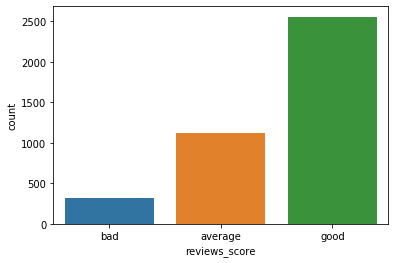

In [0]:
#visualising review score column
import seaborn as sns
sns.countplot(x='reviews_score', data=yelp_data)

In [0]:
yelp_data['reviews_score'].value_counts().sort_values(ascending=False)

good       2555
average    1126
bad         319
Name: reviews_score, dtype: int64

About 67,000 people gave good reviews,around 20,000 gave average reviews and about 13,000 gave bad reviews.


Using Keras Functional API to create a model with multiple input


In [0]:
#seperating the target variable from the feature variables
X = yelp_data.drop('reviews_score', axis=1)#feature variables
y = yelp_data['reviews_score']#target column

VECTORIZING


In [0]:

from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

from keras.utils import to_categorical
y_train = to_categorical(y_train) #splitting the target column
y_test = to_categorical(y_test)

### preprocessing the feature variables
i will filter all the text reviews and store them in the list. The text reviews will be cleaned using the preprocess_text function, which removes punctuations and numbers from the text.

In [0]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

Creating textual input for the training and test set

In [0]:
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))
    
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen)) 

Converting textual input for the training and test sets into numeric form using word embeddings

In [0]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [0]:
! pip install glove_python

     |████████████████████████████████| 266kB 2.9MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700299 sha256=06ae3d7de5b7317e190bbef5c04430c38bb6e6af3dd54c3beca56b44e23348fc
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
import glove

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#creating word embeddings with GloVe
from numpy import array
from numpy import asarray
from numpy import zeros
import io

embeddings_dictionary = dict()


with io.open('/content/gdrive/My Drive/glove.6B.100d.txt', encoding='utf8') as glove_file:
  for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



Creating meta input for training and test

In [0]:
X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values

Creating the two input layers and submodels and the multi-input model

In [0]:
from keras import models
from keras import layers

In [0]:

text_input = Input(shape=(maxlen,))#input shape set to the length of the input sentence 
metadata_input = Input(shape=(3,)) #set to the three metadata columns...

embedding_layer = layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(text_input)#embedded text in first submodel, accepts input1
LSTM_Layer_1 = layers.LSTM(128)(embedding_layer)# A LSTM will transform the vector sequence into a single vector
# containing information about the entire sequence

dense_layer_1 = layers.Dense(10, activation='relu')(metadata_input) #numerical second submodel accepts input2
dense_layer_2 = layers.Dense(10, activation='relu')(dense_layer_1)

concatenated = layers.concatenate([LSTM_Layer_1, dense_layer_2],axis=-1)


#classifier
dense_layer_3 = layers.Dense(10, activation='relu')(concatenated)#to allowing the LSTM and Embedding layer to be trained smoothly even though the main loss will be much higher in the model.

output_dropout = layers.Dropout(0.2)(dense_layer_3)
answer = Dense(3, activation='softmax')(output_dropout)


In [0]:
#final model
model = Model([text_input, metadata_input],answer)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     1776900     input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 10)           40          input_4[0][0]                    
____________________________________________________________________________________________

Network Model Plot

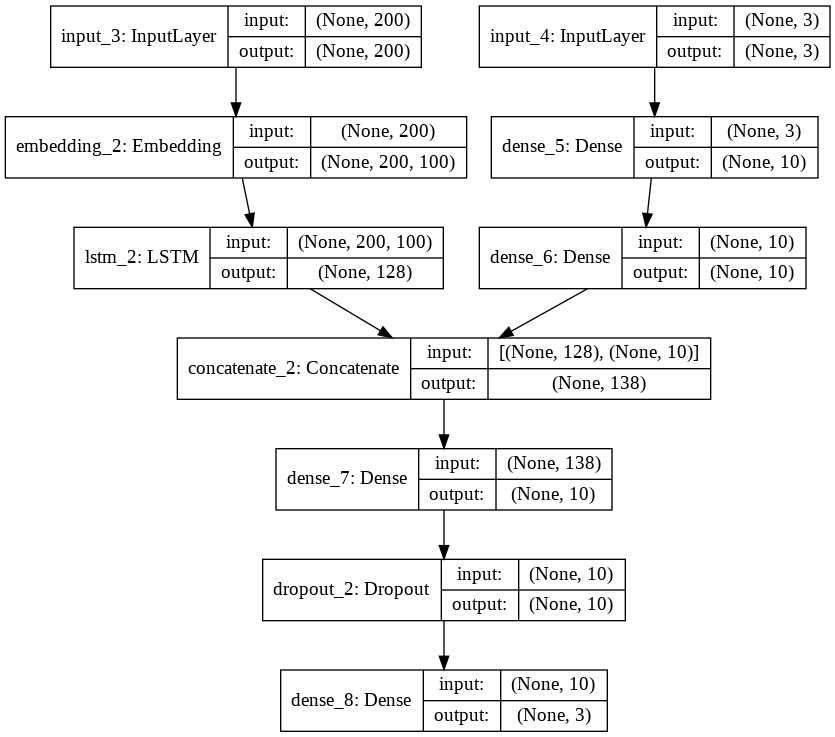

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

FITTTING THE MODEL

In [0]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 2560 samples, validate on 640 samples
Epoch 1/10
2560/2560 [==============================] - 14s 6ms/step - loss: 0.7621 - acc: 0.6809 - val_loss: 0.7837 - val_acc: 0.6578
Epoch 2/10
2560/2560 [==============================] - 13s 5ms/step - loss: 0.7642 - acc: 0.6773 - val_loss: 0.7949 - val_acc: 0.6531
Epoch 3/10
2560/2560 [==============================] - 13s 5ms/step - loss: 0.7607 - acc: 0.6797 - val_loss: 0.7873 - val_acc: 0.6484
Epoch 4/10
2560/2560 [==============================] - 13s 5ms/step - loss: 0.7465 - acc: 0.6824 - val_loss: 0.7823 - val_acc: 0.6547
Epoch 5/10
2560/2560 [==============================] - 13s 5ms/step - loss: 0.7342 - acc: 0.6871 - val_loss: 0.7908 - val_acc: 0.6562
Epoch 6/10
2560/2560 [==============================] - 13s 5ms/step - loss: 0.7357 - acc: 0.6859 - val_loss: 0.7851 - val_acc: 0.6500
Epoch 7/10
2560/2560 [==============================] - 13s 5ms/step - loss: 0.7358 - acc: 0.6848 - val_loss: 0.7994 - val_acc: 0.6453
Epoch 8/

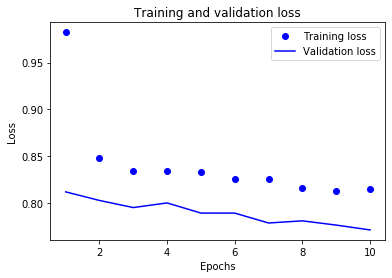

In [0]:
#Plot of the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.history
history_dict.keys()
acc = history.history["acc"]
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

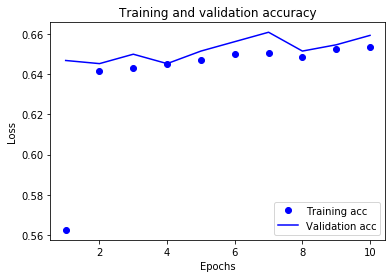

In [0]:
plt.clf() 
acc = history_dict['acc'] 
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#evaluate the model
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)#pass both the test inputs

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

800/800 [==============================] - 2s 2ms/step
Test Score: 0.8255264115333557
Test Accuracy: 0.62


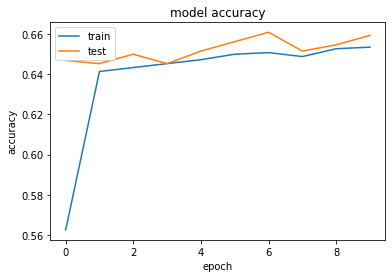

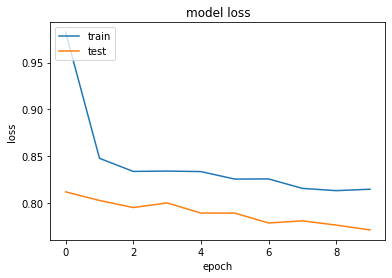

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The test accuracy is 80.53%, which is slightly less than the first model that uses textual input only. This shows that meta information in yelp_reviews is not very useful for sentiment prediction.


In [0]:
#Plot of the training and validation loss

history_dict = history.history
history_dict.keys()
acc = history.history["acc"]
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The differences for loss and accuracy values is minimal between the training and test sets, this means the model is not overfitting.

### Conclusion
 
In [ ]:
